<h1>SIT307 Group Assignment 1 notebook</h1>

<h3>Group 3</h3>
<p>By:<br>
    Aaron Norwood,218330434<br>
    Joshua Anthony, 219466473<br>
    Roger Middenway, 217602784<br>
    David Adams, 216110104<br>
    Linden Hutchinson, 218384326<br>
    Dale Orders, 219106283

# Imported libraries

In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE, RandomOverSampler
from collections import Counter

<h3> Read in the data, store if dataframe

In [42]:
df = pd.read_csv('./data/healthcare-dataset-stroke-data.csv')

# Tidying up the data

Implementing consistent capitalization and replacing underscores  spaces with hyphens in the data.

In [43]:
##convert gender to lowercase
df['gender'] = df['gender'].apply(lambda x: x.lower())

##convert work_type to lowercase ensure consistent spacing 
df['work_type'] = df['work_type'].apply(lambda x: x.lower().replace('_','-'))

##convert residence_type to lowercase
df.rename(columns={'Residence_type':'residence_type'}, inplace=True)
df['residence_type'] = df['residence_type'].apply(lambda x: x.lower())

##convert smoking_status to lowercase ensure consistent spacing 
df['smoking_status'] = df['smoking_status'].apply(lambda x: x.lower().replace(' ', '-'))

<h3>Replacing gender with dummy variables for easier visualisation

In [44]:
df['gender'] = df['gender'].str.lower().map({'male': 1, 'female': 0})

<h3> Indexes of the outliers with a bmi above 60 for verification purposes

In [45]:
indexes = [270, 358, 466, 544, 928, 1559, 2128, 2764, 2840, 3825, 4188, 4209, 4838]
for index, i in enumerate(df['bmi']):
    if index in indexes:
        print(i, end=',')

60.9,64.8,60.2,71.9,78.0,66.8,97.6,63.3,61.2,61.6,64.4,92.0,60.9,

<h3> Cap the outliers at a maximum bmi of 60

In [46]:
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 12 < bmi_value < 60 else np.nan)

<h3>Preliminary work for binning

In [47]:
##max age of 82, max bin get be set accordingly 
print("The max value in age is : " + str(df['age'].max()))
print("Total number of nulls in age is: " + str(df['age'].isnull().sum())) ##check for null
print("Total number of NAs in age is : " + str(df['age'].isna().sum())) ##check for NAs

The max value in age is : 82.0
Total number of nulls in age is: 0
Total number of NAs in age is : 0


<h3>Unknown_smoking status breakdown

In [48]:
##loop to find the number of unknown smoking entries
unknown_count = 0
##store the indexes of the unknown smoking status entries in case it's needed later
unknown_indexes = []
for index, i in enumerate(df['smoking_status']):
    if(i.lower() == 'unknown'):
        #get index and value 
        #print(index, i)
        unknown_indexes.append(index)
        unknown_count+=1
##get percentage of unknown
unknown_percent = unknown_count/len(df) * 100
unknown_percent = round(unknown_percent,4)
print("\nThe percent of entries with an unknown smoking status is: " + str(unknown_percent) + "% or " +str(unknown_count) + " entries")


The percent of entries with an unknown smoking status is: 30.2153% or 1544 entries


<h3>Checking for non-binary values</h3>
<P>Checked in heart_disease, hypertension, ever_married and stroke. Also converts ever_married to 0/1 instead of yes/no<P>

In [49]:
##check for any non-binary values in heart_disease
non_bin_heart_count = 0
for val in df['heart_disease']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_heart_count == 0):
    print("No non-binary values found in heart_disease")

##check for any non-binary values in hypertension
non_bin_hypt_count = 0
for val in df['hypertension']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_hypt_count == 0):
    print("No non-binary values found in hypertension")
    
##converts ever_married to 0/1 if not already done 
if(isinstance(df['ever_married'][0],str)):
    df['ever_married'] = df['ever_married'].str.lower().map({'yes': 1, 'no': 0})

##checks for non-binary values in ever_married
non_bin_married_count = 0
for val in df['ever_married']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_married_count == 0):
    print("No non-binary values found in ever_married")
    
##check for any non-binary values in stroke
non_bin_stroke_count = 0
for val in df['stroke']:
    if(val != 1 and val != 0):
        print(val)
if(non_bin_stroke_count == 0):
    print("No non-binary values found in stroke")

No non-binary values found in heart_disease
No non-binary values found in hypertension
No non-binary values found in ever_married
No non-binary values found in stroke


### Impute missing BMI values
<P>Replace missing BMI values with the average BMI found in rows with the same age and gender<P>

#### Check initial number of nulls

In [50]:
##get number of nulls in df
df.isnull().sum()

id                     0
gender                 1
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                  218
smoking_status         0
stroke                 0
dtype: int64

<h3>Impute missing values 

In [51]:
df['bmi_raw'] = df['bmi']

df['age'] = df['age'].apply(lambda x : round(x))

m_df = df[df['gender'] == 1]
f_df = df[df['gender'] == 0]

m_bmi_avg = m_df.groupby('age')['bmi'].mean()
f_bmi_avg = f_df.groupby('age')['bmi'].mean()
##round to one to fit with other bmi values
m_bmi_avg = round(m_bmi_avg,1)
f_bmi_avg = round(f_bmi_avg,1)

missing_vals = df[df.isnull().any(axis = 1)]

for index, row in missing_vals.iterrows():
    if row['gender'] == 1:
        df.loc[index,['bmi']] = m_bmi_avg[row['age']]
    else:
        df.loc[index,['bmi']] = f_bmi_avg[row['age']]


<h3>Checking again for nulls to verify imputation success</h3>
<p>NOTE: the values with nulls were left in a separate column in case it is needed later

In [52]:
df.isnull().sum()

id                     0
gender                 1
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
residence_type         0
avg_glucose_level      0
bmi                    0
smoking_status         0
stroke                 0
bmi_raw              218
dtype: int64

<h3>Demonstrating imputed values using the outliers above 60</h2>

In [53]:
indexes = [270, 358, 466, 544, 928, 1559, 2128, 2764, 2840, 3825, 4188, 4209, 4838]
for index, i in enumerate(df['bmi']):
    if index in indexes:
        print(i, end=',')

32.8,33.5,29.1,32.5,27.9,32.3,28.0,26.2,31.5,31.5,27.9,31.8,31.0,

<h2> Equal-width binning implementation</h2>
    <P>Uncomment if you want to use, will not work if equal-size binning has already been implemented
    if you've already applied equal-size, then read in the data-frame again<P>

In [54]:
##define labels and bins using equal width binning
#bins = [0,10,20,30,40,50,60,70,80,90]
#labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90']
##replace all age values with their corresponding bin
#df['age_bin'] = pd.cut(df['age'], bins=bins,labels=labels)

#print("total entires in each bin is:\n", df['age_bin'].value_counts())
#print("\npercentage in each bin is:\n", df['age_bin'].value_counts()/len(df)*100)

<h2> Equal-size binning implementation</h2>
<p>Implements equal-size binning using pd.qcut, binning is performed for age, glucose level and bmi

In [55]:
df['age_bin'] = pd.qcut(df['age'], q = 10, precision=1)
print("total entires in each bin is:\n", df['age_bin'].value_counts())
print("\npercentage in each bin is:\n", df['age_bin'].value_counts()/len(df)*100)

total entires in each bin is:
 (57.0, 65.0]    559
(20.0, 30.0]    545
(-0.1, 11.0]    543
(30.0, 38.0]    529
(38.0, 45.0]    519
(51.0, 57.0]    517
(65.0, 75.0]    500
(11.0, 20.0]    482
(75.0, 82.0]    465
(45.0, 51.0]    451
Name: age_bin, dtype: int64

percentage in each bin is:
 (57.0, 65.0]    10.939335
(20.0, 30.0]    10.665362
(-0.1, 11.0]    10.626223
(30.0, 38.0]    10.352250
(38.0, 45.0]    10.156556
(51.0, 57.0]    10.117417
(65.0, 75.0]     9.784736
(11.0, 20.0]     9.432485
(75.0, 82.0]     9.099804
(45.0, 51.0]     8.825832
Name: age_bin, dtype: float64


<h2>Equal-size binning for average-glucose level

In [56]:
##create 10 bins, print values for review
df['avg_glucose_level_bin'] = pd.qcut(df['avg_glucose_level'], q=10, precision=1)
print("total entires in each bin is:\n", df['avg_glucose_level_bin'].value_counts())
print("\npercentage in each bin is:\n", df['avg_glucose_level_bin'].value_counts()/len(df)*100)

total entires in each bin is:
 (108.5, 124.2]    512
(80.0, 85.6]      512
(65.8, 73.8]      512
(192.2, 271.7]    511
(98.9, 108.5]     511
(91.9, 98.9]      511
(55.0, 65.8]      511
(124.2, 192.2]    510
(85.6, 91.9]      510
(73.8, 80.0]      510
Name: avg_glucose_level_bin, dtype: int64

percentage in each bin is:
 (108.5, 124.2]    10.019569
(80.0, 85.6]      10.019569
(65.8, 73.8]      10.019569
(192.2, 271.7]    10.000000
(98.9, 108.5]     10.000000
(91.9, 98.9]      10.000000
(55.0, 65.8]      10.000000
(124.2, 192.2]     9.980431
(85.6, 91.9]       9.980431
(73.8, 80.0]       9.980431
Name: avg_glucose_level_bin, dtype: float64


<h2>Equal-size binning for bmi

In [57]:
df['bmi_bin'] = pd.qcut(df['bmi'], q=10, precision=1)
print("total entires in each bin is:\n", df['bmi_bin'].value_counts())
print("\npercentage in each bin is:\n", df['bmi_bin'].value_counts()/len(df)*100)

total entires in each bin is:
 (12.200000000000001, 19.8]    522
(28.2, 29.9]                  520
(24.7, 26.6]                  519
(34.2, 38.6]                  516
(29.9, 31.8]                  514
(22.6, 24.7]                  510
(38.6, 59.7]                  506
(26.6, 28.2]                  504
(19.8, 22.6]                  502
(31.8, 34.2]                  497
Name: bmi_bin, dtype: int64

percentage in each bin is:
 (12.200000000000001, 19.8]    10.215264
(28.2, 29.9]                  10.176125
(24.7, 26.6]                  10.156556
(34.2, 38.6]                  10.097847
(29.9, 31.8]                  10.058708
(22.6, 24.7]                   9.980431
(38.6, 59.7]                   9.902153
(26.6, 28.2]                   9.863014
(19.8, 22.6]                   9.823875
(31.8, 34.2]                   9.726027
Name: bmi_bin, dtype: float64


In [58]:
df.isnull().sum()

id                         0
gender                     1
age                        0
hypertension               0
heart_disease              0
ever_married               0
work_type                  0
residence_type             0
avg_glucose_level          0
bmi                        0
smoking_status             0
stroke                     0
bmi_raw                  218
age_bin                    0
avg_glucose_level_bin      0
bmi_bin                    0
dtype: int64

In [59]:
df['gender'] = df['gender'].replace(np.nan, 0)

In [60]:
df.isnull().sum()

id                         0
gender                     0
age                        0
hypertension               0
heart_disease              0
ever_married               0
work_type                  0
residence_type             0
avg_glucose_level          0
bmi                        0
smoking_status             0
stroke                     0
bmi_raw                  218
age_bin                    0
avg_glucose_level_bin      0
bmi_bin                    0
dtype: int64

In [61]:
##I realised that gender had all been mapped to float, so I've fixed that he
df['gender'] = df['gender'].astype(int)

In [62]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_raw,age_bin,avg_glucose_level_bin,bmi_bin
0,9046,1,67,0,1,1,private,urban,228.69,36.6,formerly-smoked,1,36.6,"(65.0, 75.0]","(192.2, 271.7]","(34.2, 38.6]"
1,51676,0,61,0,0,1,self-employed,rural,202.21,29.1,never-smoked,1,NaN,"(57.0, 65.0]","(192.2, 271.7]","(28.2, 29.9]"
2,31112,1,80,0,1,1,private,rural,105.92,32.5,never-smoked,1,32.5,"(75.0, 82.0]","(98.9, 108.5]","(31.8, 34.2]"
3,60182,0,49,0,0,1,private,urban,171.23,34.4,smokes,1,34.4,"(45.0, 51.0]","(124.2, 192.2]","(34.2, 38.6]"
4,1665,0,79,1,0,1,self-employed,rural,174.12,24.0,never-smoked,1,24.0,"(75.0, 82.0]","(124.2, 192.2]","(22.6, 24.7]"


In [63]:
df2 = df.drop(['id','work_type','residence_type','smoking_status','bmi_raw','age_bin','avg_glucose_level_bin','bmi_bin'],axis=1)

In [64]:
df3 = df.drop(['id','work_type','residence_type','smoking_status','bmi_raw','avg_glucose_level','bmi'],axis=1)

In [65]:
df2.head()

,gender,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,stroke
0,1,67,0,1,1,228.69,36.6,1
1,0,61,0,0,1,202.21,29.1,1
2,1,80,0,1,1,105.92,32.5,1
3,0,49,0,0,1,171.23,34.4,1
4,0,79,1,0,1,174.12,24.0,1


In [66]:
df3.head()

,gender,age,hypertension,heart_disease,ever_married,stroke,age_bin,avg_glucose_level_bin,bmi_bin
0,1,67,0,1,1,1,"(65.0, 75.0]","(192.2, 271.7]","(34.2, 38.6]"
1,0,61,0,0,1,1,"(57.0, 65.0]","(192.2, 271.7]","(28.2, 29.9]"
2,1,80,0,1,1,1,"(75.0, 82.0]","(98.9, 108.5]","(31.8, 34.2]"
3,0,49,0,0,1,1,"(45.0, 51.0]","(124.2, 192.2]","(34.2, 38.6]"
4,0,79,1,0,1,1,"(75.0, 82.0]","(124.2, 192.2]","(22.6, 24.7]"


In [67]:
df3.dtypes

gender                      int64
age                         int64
hypertension                int64
heart_disease               int64
ever_married                int64
stroke                      int64
age_bin                  category
avg_glucose_level_bin    category
bmi_bin                  category
dtype: object

# Modelling

## Random Forest

The major issue with random forest is the balancing accuracy and recall, this can be improved by using stratified k fold cross validation 

In [317]:
y = df2['stroke']
X = df2.drop('stroke',axis=1)

# Lower test splits (more training) seems to provide better recall
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Fix the balancing issues by using oversampling techniques
X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)

In [315]:
# Max depth of 5 seems to give the best recall
rf = RandomForestClassifier(random_state=5, max_depth=5, n_estimators=100, bootstrap=False)
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

In [264]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.72      0.83       970
           1       0.12      0.73      0.21        52

    accuracy                           0.72      1022
   macro avg       0.55      0.73      0.52      1022
weighted avg       0.94      0.72      0.80      1022



In [318]:
rf = RandomForestClassifier(random_state=5, max_depth=5, n_estimators=100, bootstrap=False)
skf = StratifiedKFold(shuffle=True, n_splits=10)
scores = cross_val_score(rf, X_train_res, y_train_res, cv=skf)

print('Cross-validation scores with 10 folds:')
print('')
print(f'Scores:\n{scores}')
print('')
print(f'accuracy: {round(np.mean(scores), 4)}')
print(f"ROC AUC: {round(cross_val_score(rf, X_train_res, y_train_res, cv=skf, scoring='roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(rf, X_train_res, y_train_res, cv=skf, scoring='precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(rf, X_train_res, y_train_res, cv=skf, scoring='recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(rf, X_train_res, y_train_res, cv=skf, scoring='f1').mean(), 2)}")

Cross-validation scores with 10 folds:

Scores:
[0.81771502 0.81899872 0.83033419 0.83161954 0.8251928  0.84190231
 0.81233933 0.83161954 0.8251928  0.8033419 ]

accuracy: 0.8238
ROC AUC: 0.907
precision: 0.77
recall: 0.93
f1: 0.84


Accuracy:  0.7240704500978473


<AxesSubplot:>

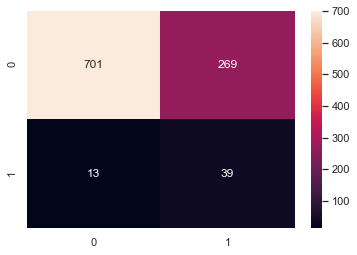

In [200]:
ac = accuracy_score(y_test, y_pred)
print('Accuracy: ', ac)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm , annot=True, fmt="d")

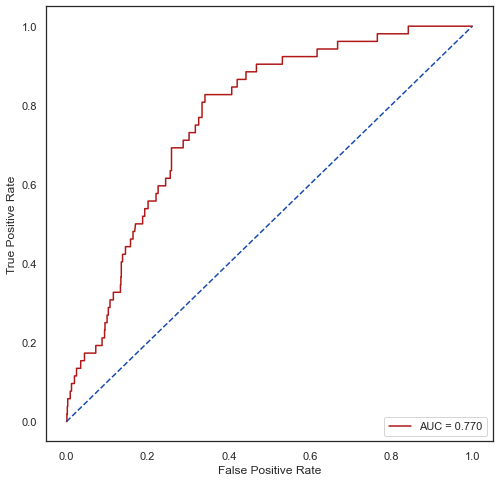

In [157]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate, true_positive_rate, color = '#b01717', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Logistic Regression

In [294]:
y = df2['stroke']
X = df2.drop('stroke',axis=1)

# Lower test splits (more training) seems to provide better recall
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Fix the balancing issues by using oversampling techniques
X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)

In [295]:
lr = LogisticRegression(random_state=5, max_iter=1000)
lr.fit(X_train_res, y_train_res)
#lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:,1]

In [296]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       970
           1       0.13      0.62      0.21        52

    accuracy                           0.76      1022
   macro avg       0.55      0.69      0.53      1022
weighted avg       0.93      0.76      0.83      1022



In [297]:
skf = StratifiedKFold(shuffle=True, n_splits=5)
scores = cross_val_score(lr, X_train_res, y_train_res, cv=skf)

print('Cross-validation scores with 10 folds:')
print('')
print(f'Scores:\n{scores}')
print('')
print(f'accuracy: {round(np.mean(scores), 4)}')
print(f"ROC AUC: {round(cross_val_score(lr, X_train_res, y_train_res, cv=skf, scoring='roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(lr, X_train_res, y_train_res, cv=skf, scoring='precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(lr, X_train_res, y_train_res, cv=skf, scoring='recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(lr, X_train_res, y_train_res, cv=skf, scoring='f1').mean(), 2)}")

Cross-validation scores with 10 folds:

Scores:
[0.76364804 0.78805395 0.77763496 0.77634961 0.80141388]

accuracy: 0.7814
ROC AUC: 0.872
precision: 0.78
recall: 0.79
f1: 0.78


Accuracy:  0.7622309197651663


<AxesSubplot:>

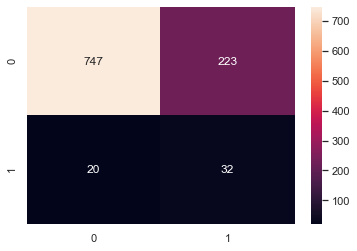

In [298]:
ac = accuracy_score(y_test, y_pred)
print('Accuracy: ', ac)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm , annot=True, fmt="d")

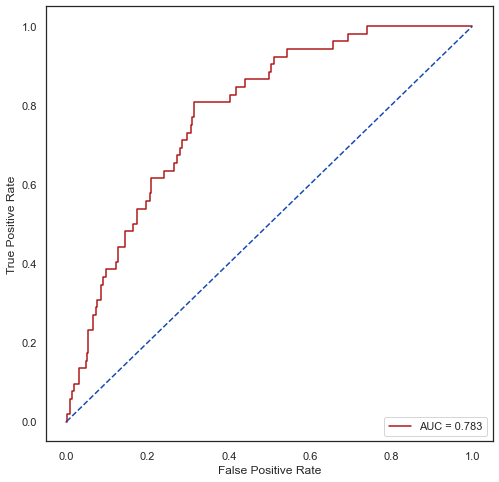

In [299]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate, true_positive_rate, color='#b01717', label='AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## SVM

In [305]:
y = df2['stroke']
X = df2.drop('stroke', axis=1)

# Lower test splits (more training) seems to provide better recall
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Fix the balancing issues by using oversampling techniques
X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)

In [306]:
svc = SVC(random_state=5, probability=True)
svc.fit(X_train_res, y_train_res)
y_pred = svc.predict(X_test)
y_prob = svc.predict_proba(X_test)[:,1]

In [307]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.71      0.82       970
           1       0.13      0.81      0.22        52

    accuracy                           0.71      1022
   macro avg       0.56      0.76      0.52      1022
weighted avg       0.94      0.71      0.79      1022



In [177]:
skf = StratifiedKFold(shuffle=True, n_splits=10)
scores = cross_val_score(svc, X_train_res, y_train_res, cv=skf)

print('Cross-validation scores with 10 folds:')
print('')
print(f'Scores:\n{scores}')
print('')
print(f'accuracy: {round(np.mean(scores), 4)}')
print(f"ROC AUC: {round(cross_val_score(svc, X_train_res, y_train_res, cv=skf, scoring='roc_auc').mean(), 3)}")
print(f"precision: {round(cross_val_score(svc, X_train_res, y_train_res, cv=skf, scoring='precision').mean(), 2)}")
print(f"recall: {round(cross_val_score(svc, X_train_res, y_train_res, cv=skf, scoring='recall').mean(), 2)}")
print(f"f1: {round(cross_val_score(svc, X_train_res, y_train_res, cv=skf, scoring='f1').mean(), 2)}")

Cross-validation scores with 10 folds:

Scores:
[0.75481386 0.75609756 0.77120823 0.77634961 0.7596401  0.73136247
 0.77377892 0.78534704 0.75064267 0.78791774]

accuracy: 0.7647
ROC AUC: 0.845
precision: 0.73
recall: 0.83
f1: 0.78


Accuracy:  0.6956947162426614


<AxesSubplot:>

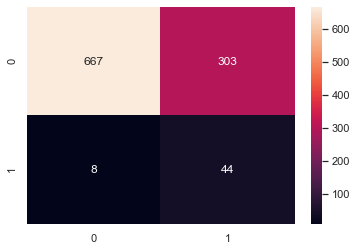

In [303]:
ac = accuracy_score(y_test, y_pred)
print('Accuracy: ', ac)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm , annot=True, fmt="d")

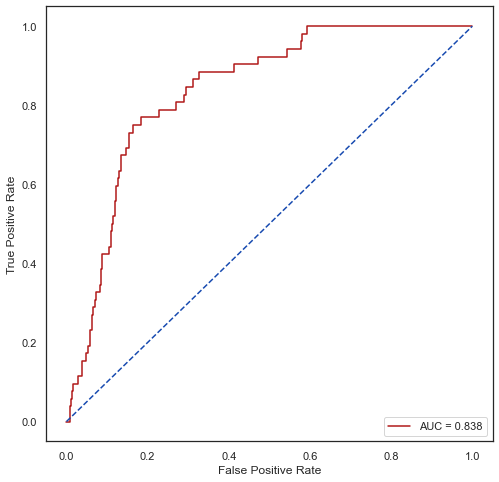

In [304]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(false_positive_rate, true_positive_rate)

sns.set_theme(style = 'white')
plt.figure(figsize = (8, 8))
plt.plot(false_positive_rate, true_positive_rate, color='#b01717', label='AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], linestyle = '--', color = '#174ab0')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()